# CarDEC SCT Normalization Notebook

This notebook implements analyzes the performance of CarDEC, when using the SCTransform method to preprocess the data before feeding it into CarDEC.

## Analysis Preparation

Here, we prepare for analysis. We import requisite packages and define helper functions.

In [1]:
"""Broadly useful python packages"""
import pandas as pd
import os
import numpy as np
import pickle
from copy import deepcopy
from shutil import move
import warnings
from scipy.io import mmread

"""Machine learning and single cell packages"""
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
import sklearn.metrics as metrics
from sklearn.metrics import adjusted_rand_score as ari, normalized_mutual_info_score as nmi
import scanpy as sc
from anndata import AnnData
import seaborn as sns

"""CarDEC"""
from CarDEC import CarDEC_API
from CarDEC.CarDEC_utils import normalize_scanpy

%matplotlib inline
%load_ext autoreload

%autoreload 2

In [2]:
"""Miscellaneous useful functions"""

def read_cortex(path):
    adata = AnnData(mmread(os.path.join(path, "count.umis.txt"))).T
    urls_ = ["meta_combined.txt", "genes.txt", "cell.names.new.txt"]
    urls_ = [os.path.join(path, x) for x in urls_]
    metadata, genes, cells = [pd.read_csv(url_, sep = '\t') for url_ in urls_]
    genes, cells = list(genes['scientific']), list(cells['cellname'])
    indices = [x in list(metadata["NAME"]) for x in cells]
    adata.obs.index, adata.var.index = cells, genes
    adata.X = adata.X.toarray()
    adata = adata[indices]
    adata.obs = metadata
    
    sc.pp.filter_cells(adata, min_genes = 200)
    sc.pp.filter_genes(adata, min_cells = 30)
    
    adata = adata[adata.obs["CellType"].values != "Unassigned"]
    print(adata)
    
    return(adata)

def purity_score(y_true, y_pred):
    """A function to compute cluster purity"""
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)

    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def convert_string_to_encoding(string, vector_key):
    """A function to convert a string to a numeric encoding"""
    return np.argwhere(vector_key == string)[0][0]

def convert_vector_to_encoding(vector):
    """A function to convert a vector of strings to a dense numeric encoding"""
    vector_key = np.unique(vector)
    vector_strings = list(vector)
    vector_num = [convert_string_to_encoding(string, vector_key) for string in vector_strings]
    
    return vector_num
    
def build_dir(dir_path):
    subdirs = [dir_path]
    substring = dir_path

    while substring != '':
        splt_dir = os.path.split(substring)
        substring = splt_dir[0]
        subdirs.append(substring)
        
    subdirs.pop()
    subdirs = [x for x in subdirs if os.path.basename(x) != '..']

    n = len(subdirs)
    subdirs = [subdirs[n - 1 - x] for x in range(n)]
    
    for dir_ in subdirs:
        if not os.path.isdir(dir_):
            os.mkdir(dir_)
    
def find_resolution(adata_, n_clusters, random = 0): 
    adata = adata_.copy()
    obtained_clusters = -1
    iteration = 0
    resolutions = [0., 1000.]

    while obtained_clusters != n_clusters and iteration < 50:
        current_res = sum(resolutions)/2
        sc.tl.louvain(adata, resolution = current_res, random_state = random)
        labels = adata.obs['louvain']
        obtained_clusters = len(np.unique(labels))

        if obtained_clusters < n_clusters:
            resolutions[0] = current_res
        else:
            resolutions[1] = current_res

        iteration = iteration + 1

    return current_res

rpy2.robjects.numpy2ri.activate()
robjects.r("source('sct_norm.R')")

sct_r = robjects.globalenv['sct_norm']

def SCTransform(adata):
    inputs = (adata.X.copy(), adata.obs.index.values, adata.var.index.values)
    sct_res = sct_r(*inputs)
    return np.asarray(sct_res)

metrics_ = [ari, nmi, purity_score]

Now, let's read the data in, and take a look at the cell type distribution.

/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


View of AnnData object with n_obs × n_vars = 13423 × 20095
    obs: 'NAME', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method', 'n_genes'
    var: 'n_cells'


/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The number of cells of type: Astrocyte is 1384
The number of cells of type: Endothelial is 399
The number of cells of type: Excitatory neuron is 7776
The number of cells of type: Inhibitory neuron is 2471
The number of cells of type: Microglia is 311
The number of cells of type: OPC is 276
The number of cells of type: Oligodendrocyte is 777
The number of cells of type: Pericyte is 29


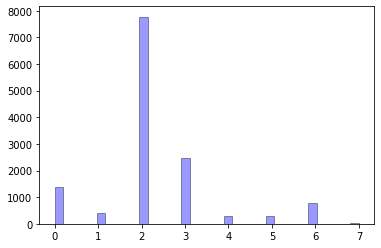

In [3]:
adata = read_cortex("../Data/cortex")

celltype = adata.obs['CellType'].values
celltype_vec = convert_vector_to_encoding(celltype)

sns.distplot(celltype_vec, hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

celltype_key = np.unique(adata.obs['CellType'].values)

for type_ in celltype_key:
    ntype = sum([x == type_ for x in celltype])
    print("The number of cells of type: " + type_ + " is " + str(ntype))

## Figure Data

In [4]:
ARI_data_gene = {'ARI': [0]*3,
                 'NMI': [0]*3,
                 'Purity': [0]*3,
                 'Method': ['CarDEC SCT', 'CarDEC SCT by Batch', 'CarDEC Standard']}
ARI_data_gene = pd.DataFrame(ARI_data_gene)

figure_path_supplement = "../Figures/cortex_supplement"

build_dir(figure_path_supplement)

## Analyze the data with CarDEC (SCT Only)

In this section, I use SCTransform alone to preprocess the data before feeding it into CarDEC.

In [6]:
tmp = adata.copy()
tmp = normalize_scanpy(tmp, n_high_var = 2000, batch_key = 'Method')
vtype = tmp.var['Variance Type']

... storing 'CellType' as categorical
... storing 'Experiment' as categorical
... storing 'Method' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [7]:
sct_res = SCTransform(adata)

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 20095 by 13423

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 13423 cells



  |======================================================================| 100%


R[write to console]: There are 5 estimated thetas smaller than 1e-07 - will be set to 1e-07

R[write to console]: Found 43 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 20095 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.837221 mins



In [8]:
adata.layers['normalized input'] = sct_res
adata.var['Variance Type'] = vtype.values

In [9]:
CarDEC = CarDEC_API(adata, weights_dir = "Cortex All/CarDEC_LVG SCT Weights", batch_key = 'Method', n_high_var = 2000, preprocess = False)

In [10]:
CarDEC.build_model(n_clusters = 6)

Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of th

In [11]:
CarDEC.make_inference()

Weight index file detected, loading weights.
CarDEC Model weights loaded successfully.

The CarDEC model is now making inference on the data matrix.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Inference completed, results returned.
 


As we can see, CarDEC performs very poorly when using purely SCT normalized inputs.

... storing 'CellType' as categorical
... storing 'Experiment' as categorical
... storing 'Method' as categorical
... storing 'cell_type' as categorical


CarDEC Denoising Results using all denoised features
ARI = 0.1824
NMI = 0.3186
Purity = 0.6635


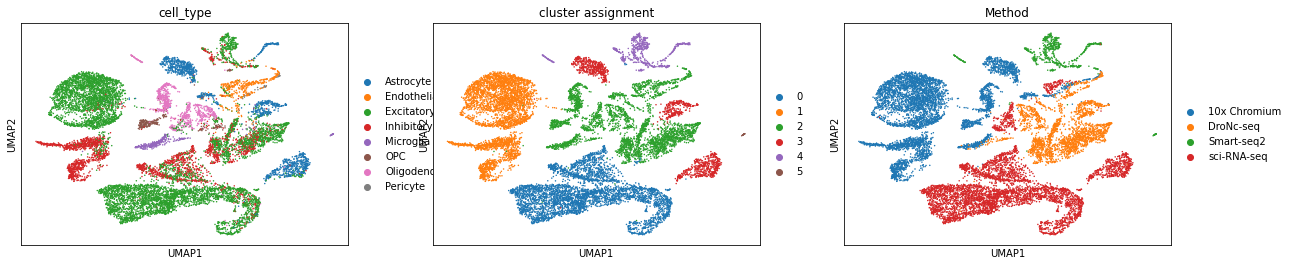

In [12]:
"""Assessing denoised zscore features"""

temporary = AnnData(deepcopy(CarDEC.dataset.layers['denoised']))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['CellType']

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 6)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "Method"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("CarDEC Denoising Results using all denoised features")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

"""Figure info for main paper"""
ARI_data_gene.iloc[0,:3] = ARI, NMI, Purity
DF = pd.DataFrame(temporary.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Sequencing Method'] = temporary.obs['Method'].values
DF['Cell Type'] = temporary.obs['CellType'].values
DF.index = temporary.obs.index

base_path = 'CarDEC SCT.csv'
path = os.path.join(figure_path_supplement, base_path)

DF.to_csv(path)

## Analyze the data with CarDEC (SCT + zscore by Batch)

In this section, I use SCTransform, followed by a z-score normalization of each gene's expression (done for each batch separately).

In [28]:
adata = read_cortex("../Data/cortex")

/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


View of AnnData object with n_obs × n_vars = 13423 × 20095
    obs: 'NAME', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method', 'n_genes'
    var: 'n_cells'


In [29]:
tmp = adata.copy()
tmp = normalize_scanpy(tmp, n_high_var = 2000, batch_key = 'Method')
vtype = tmp.var['Variance Type']

... storing 'CellType' as categorical
... storing 'Experiment' as categorical
... storing 'Method' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [30]:
sct_res = SCTransform(adata)

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 20095 by 13423

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 13423 cells



  |======================================================================| 100%


R[write to console]: There are 6 estimated thetas smaller than 1e-07 - will be set to 1e-07

R[write to console]: Found 34 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 20095 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.91932 mins



In [31]:
adata.layers['normalized input'] = sct_res
adata.var['Variance Type'] = vtype.values

In [32]:
adata_ = adata.copy()

In [33]:
batch_keys = np.unique(adata.obs['Method'])

In [34]:
for batch in batch_keys:
    indices = adata.obs['Method'] == batch
    tmp = AnnData(adata.layers['normalized input'][indices])
    sc.pp.scale(tmp)
    adata.layers['normalized input'][indices] = tmp.X

In [35]:
CarDEC = CarDEC_API(adata, weights_dir = "Cortex All/CarDEC_LVG SCT_bybatch Weights", batch_key = 'Method', n_high_var = 2000, preprocess = False)

In [36]:
CarDEC.build_model(n_clusters = 6)

Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of th

In [37]:
CarDEC.make_inference()

Weight index file detected, loading weights.
CarDEC Model weights loaded successfully.

The CarDEC model is now making inference on the data matrix.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Inference completed, results returned.
 


Here, CarDEC performed significantly better after we added gene normalization following SCT normalization.

CarDEC Denoising Results using all denoised features
ARI = 0.7426
NMI = 0.6799
Purity = 0.8878


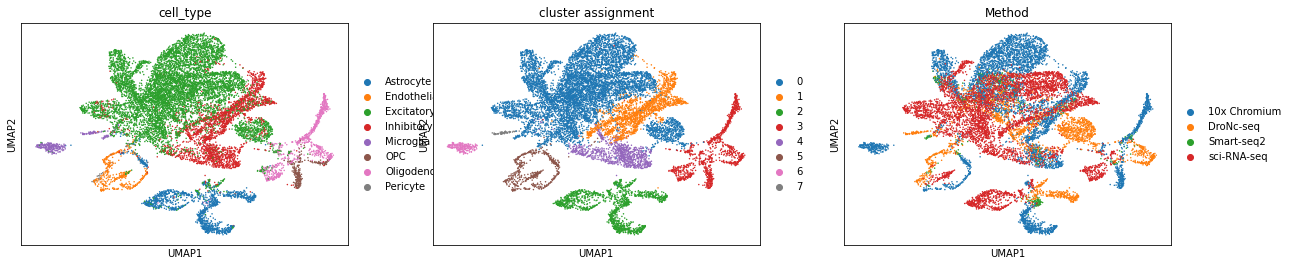

In [40]:
"""Assessing denoised zscore features"""

temporary = AnnData(deepcopy(CarDEC.dataset.layers['denoised']))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['CellType']

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 8)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "Method"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("CarDEC Denoising Results using all denoised features")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

"""Figure info for main paper"""
ARI_data_gene.iloc[1,:3] = ARI, NMI, Purity
DF = pd.DataFrame(temporary.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Sequencing Method'] = temporary.obs['Method'].values
DF['Cell Type'] = temporary.obs['CellType'].values
DF.index = temporary.obs.index

base_path = 'CarDEC SCT by Batch.csv'
path = os.path.join(figure_path_supplement, base_path)

DF.to_csv(path)

## Analyze the data with CarDEC (Standard Normalization)

In this section, I use CarDEC's standard normalization workflow, as described in the paper.

In [41]:
CarDEC = CarDEC_API(adata, weights_dir = "Cortex All/CarDEC_LVG Weights", batch_key = 'Method', n_high_var = 2000)

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Now, let's build the CarDEC model in TensorFlow by calling CarDEC.build_model. Doing so will initialize the high variance feature autoencoder. By default, the CarDEC API will try to load the weights for this autoencoder from the weights directory. If the weights cannot be found, then the autoencoder will be trained from scratch with automatic differentiation, and its weights will be saved.

We use the mean squared error noise model as the loss of our autoencoder since this noise distribution is very flexible and adaptable to different data modalities (UMI and non-UMI datasets, among others). We will set the cluster weight to be 1, which will weight the clustering loss and reconstruction loss equally during the cluster refinement step.

In [42]:
CarDEC.build_model(n_clusters = 6)

Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                260256    
_________________________________________________________________
decoder (Sequential)         (None, 2000)              262224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2320416   
_________________________________________________________________
decoderLVG (Sequential)      (1, 18095)                2342575   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  192       
Total params: 5,185,663
Trainable params: 5,185,663
Non-trainable para

Now we will make inference on the dataset with the CarDEC model. By default the CarDEC API will attempt to load the weights for the full CarDEC model from the weights directory. If the weights cannot be found, then the main CarDEC model will be trained from scratch with automatic differentiation, and its weights will be saved.

Once the weights for the full CarDEC model are initialized, the API will use the model to make inference on the data. This will add several outputs to CarDEC.dataset

layers: 
    1. ["denoised"] contains denoised batch corrected features in the gene space. These features are useful for downstream analyses in the gene expression space, like differential expression analysis.

obsm: 
    1. ["cluster memberships"] an array, where element (i,j) is the probability that cell i is in cluster j
    2. ["precluster denoised"] an array, where element (i,j) is the denoised expression value of high variance gene j in cell i. This denoised representation is avalible only for high variance genes.
    3. ["embedding"] the low-dimension embedding corresponding to high variance features (after fine tuning)
    4. ["LVG embedding"] the combined low-dimension embedding (more precisely, the embedding from the high variance encoder concatenated to the embedding from the low variance encoder). This axis array will be created ONLY if 
    low variance genes are modeled.
    5. ["precluster embedding"] the low-dimension embedding corresponding to high variance features (before fine 
    tuning)
    6. ["initial assignments"] the cluster assignments before finetuning. These assignments are identified only if the autoencoder is trained from scratch. If the autoencoder weights are loaded instead of trained from scratch, this vector will be set to all zeros.

In [43]:
CarDEC.make_inference()

Weight index file detected, loading weights.
CarDEC Model weights loaded successfully.

The CarDEC model is now making inference on the data matrix.
Inference completed, results returned.
 


As we can see, CarDEC performed best using its simple standard normalization workflow.

CarDEC Denoising Results using all denoised features
ARI = 0.7634
NMI = 0.7286
Purity = 0.8875


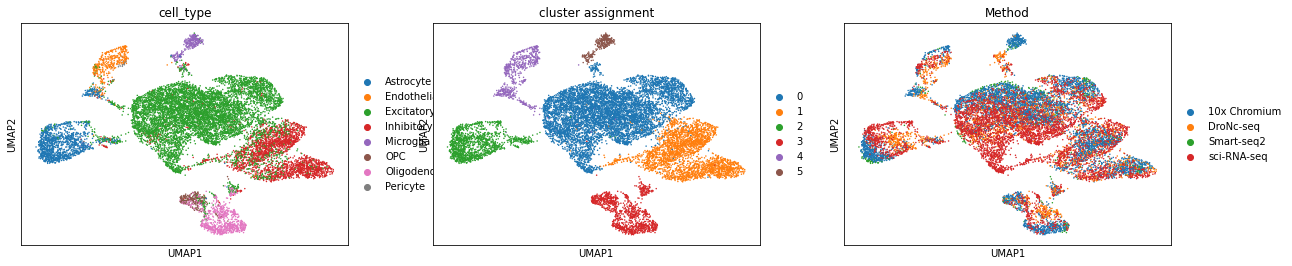

In [44]:
"""Assessing denoised zscore features"""

temporary = AnnData(deepcopy(CarDEC.dataset.layers['denoised']))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['CellType']

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 6)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "Method"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("CarDEC Denoising Results using all denoised features")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

"""Figure info for main paper"""
ARI_data_gene.iloc[2,:3] = ARI, NMI, Purity
DF = pd.DataFrame(temporary.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Sequencing Method'] = temporary.obs['Method'].values
DF['Cell Type'] = temporary.obs['CellType'].values
DF.index = temporary.obs.index

base_path = 'CarDEC Standard.csv'
path = os.path.join(figure_path_supplement, base_path)

DF.to_csv(path)

base_path = 'SCT ARIs.csv'
path = os.path.join(figure_path_supplement, base_path)
ARI_data_gene.to_csv(path)